## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

(2225, 3)
[[ 0.7445486  -0.3807246  -0.54835769]
 [ 0.88823227 -0.05451488 -0.45614862]
 [ 0.84155306 -0.01404477 -0.53999185]
 ...
 [ 0.91047073 -0.12686084 -0.39363609]
 [ 0.89408917  0.05642246 -0.44432089]
 [ 0.85099132 -0.50196791  0.15440854]]


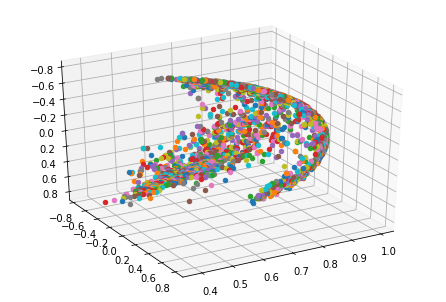

In [2]:
all_texts=[]
Y = []
# os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
print(vectors_dense_svd.shape)
fig=plt.figure()
ax = Axes3D(fig)
X = vectors_dense_svd
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [17]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(confusion_matrix(Y, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [18]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    population = population_initialization()
    gen=0
    return_chromosome=[]
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
#         purity = davies_bouldin_index(population[fitness.index(max(fitness))])
#         print("Generation: "+str(gen)+" | Purity: "+str(purity))
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    return population[fitness.index(max(fitness))]

In [19]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#333333','#84ff33','#33ffee','#3395ff','#d2a8fc','#ffffff']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 120)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 7.702718402384559
Generation: 2 | Best fitness: 8.68888792708818
Generation: 3 | Best fitness: 9.73031269797881
Generation: 4 | Best fitness: 10.215807019508905
Generation: 5 | Best fitness: 9.277128483236234
Generation: 6 | Best fitness: 9.221454490439571
Generation: 7 | Best fitness: 9.604210161577615
Generation: 8 | Best fitness: 9.141662045907793
Generation: 9 | Best fitness: 9.928106918208861
Generation: 10 | Best fitness: 9.55394363393604
Generation: 11 | Best fitness: 9.55394363393606
Generation: 12 | Best fitness: 9.817862721454818
Generation: 13 | Best fitness: 9.817862721454803
Generation: 14 | Best fitness: 8.73436940066407
Generation: 15 | Best fitness: 9.045022303629269
Generation: 16 | Best fitness: 10.643617115893413
Generation: 17 | Best fitness: 9.961276215148422
Generation: 18 | Best fitness: 7.771313419596493
Generation: 19 | Best fitness: 9.411951415148703
Generation: 20 | Best fitness: 8.350877734015121
Generation: 21 | Best fitness: 9

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 83 | Best fitness: 11.611440216032888
Generation: 84 | Best fitness: 9.995301783630367
Generation: 85 | Best fitness: 9.680725986234247
Generation: 86 | Best fitness: 8.506828208413687
Generation: 87 | Best fitness: 8.503043652782466
Generation: 88 | Best fitness: 8.778152124582189
Generation: 89 | Best fitness: 10.27907195907761
Generation: 90 | Best fitness: 8.654867575634706
Generation: 91 | Best fitness: 9.962456519035378
Generation: 92 | Best fitness: 9.627362800703825
Generation: 93 | Best fitness: 10.04704374394692
Generation: 94 | Best fitness: 9.426712560512051
Generation: 95 | Best fitness: 8.904082032530912
Generation: 96 | Best fitness: 10.15370874053415
Generation: 97 | Best fitness: 11.73788707156202
Generation: 98 | Best fitness: 10.204470694576353
Generation: 99 | Best fitness: 7.474576119922263
Generation: 100 | Best fitness: 9.873763910661234
DB Index        :3.8349725297570822
Silhoutte Index :0.5400279282388378
703
1224
298


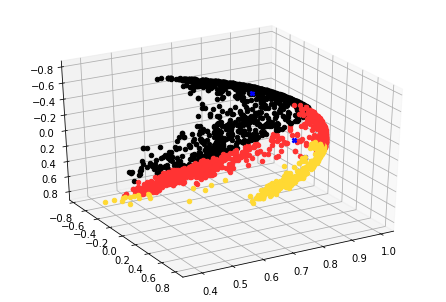

In [20]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# F1, Accuracy = supervised_scores(chromosome)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 18.814247366464237
Generation: 2 | Best fitness: 18.737809667753798
Generation: 3 | Best fitness: 16.972253314804902
Generation: 4 | Best fitness: 18.651107930395504
Generation: 5 | Best fitness: 22.715854778997294
Generation: 6 | Best fitness: 22.111851317789153
Generation: 7 | Best fitness: 19.655084684563388
Generation: 8 | Best fitness: 34.73180815399131
Generation: 9 | Best fitness: 30.9143384338248
Generation: 10 | Best fitness: 22.783733819197504
Generation: 11 | Best fitness: 23.39346652477665
Generation: 12 | Best fitness: 26.280611635955147
Generation: 13 | Best fitness: 22.732605574319983
Generation: 14 | Best fitness: 23.390712823915408
Generation: 15 | Best fitness: 18.13330434562329
Generation: 16 | Best fitness: 21.9179809267565
Generation: 17 | Best fitness: 23.626351602651315
Generation: 18 | Best fitness: 23.626351602651265
Generation: 19 | Best fitness: 17.7919140130195
Generation: 20 | Best fitness: 16.509208788263265
Generation: 21 | B

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 60 | Best fitness: 24.93620589380014
Generation: 61 | Best fitness: 25.308240232618868
Generation: 62 | Best fitness: 20.21390709639124
Generation: 63 | Best fitness: 25.260941811939485
Generation: 64 | Best fitness: 21.434966583662288
Generation: 65 | Best fitness: 25.859488447226443
Generation: 66 | Best fitness: 25.859488447226397
Generation: 67 | Best fitness: 27.013294275377294
Generation: 68 | Best fitness: 27.417224652687615
Generation: 69 | Best fitness: 26.492282379015016
Generation: 70 | Best fitness: 26.492282379015002
Generation: 71 | Best fitness: 25.584255744876298
Generation: 72 | Best fitness: 32.28666173201538
Generation: 73 | Best fitness: 28.046986407031792
Generation: 74 | Best fitness: 22.26540439415224
Generation: 75 | Best fitness: 23.657546773547743
Generation: 76 | Best fitness: 26.30916179456912
Generation: 77 | Best fitness: 23.335838086770384
Generation: 78 | Best fitness: 23.40023830340436
Generation: 79 | Best fitness: 24.33068284687001
Generat

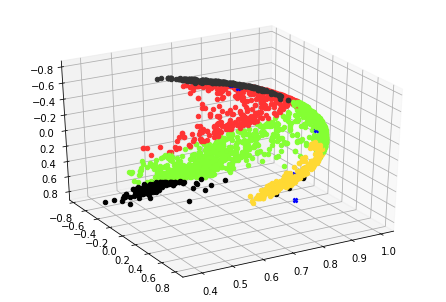

In [21]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# F1, Accuracy = supervised_scores(chromosome)
# print("Accuracy        :"+str(Accuracy))
# print("F1 Score        :"+str(F1))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 26.178393783389712
Generation: 2 | Best fitness: 42.39761643513363
Generation: 3 | Best fitness: 42.3976164351337
Generation: 4 | Best fitness: 30.624694100921356
Generation: 5 | Best fitness: 26.429073862429473
Generation: 6 | Best fitness: 26.749740962033272
Generation: 7 | Best fitness: 27.21174438662916
Generation: 8 | Best fitness: 27.29072775837768
Generation: 9 | Best fitness: 29.102155445741715
Generation: 10 | Best fitness: 29.344091440944503
Generation: 11 | Best fitness: 32.23026006449936
Generation: 12 | Best fitness: 30.82279834114909
Generation: 13 | Best fitness: 29.629187128667002
Generation: 14 | Best fitness: 25.058330582516373
Generation: 15 | Best fitness: 28.51220915800179
Generation: 16 | Best fitness: 28.12865722427793
Generation: 17 | Best fitness: 30.090040246791713
Generation: 18 | Best fitness: 28.768031870687366
Generation: 19 | Best fitness: 28.768031870687395
Generation: 20 | Best fitness: 24.929665619648812
Generation: 21 | B

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 44 | Best fitness: 28.589523341450644
Generation: 45 | Best fitness: 25.715911460480516
Generation: 46 | Best fitness: 25.715911460480477
Generation: 47 | Best fitness: 28.90853361133261
Generation: 48 | Best fitness: 23.40174719441267
Generation: 49 | Best fitness: 24.47261626554947
Generation: 50 | Best fitness: 24.554757243956047
Generation: 51 | Best fitness: 24.66328640392017


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 52 | Best fitness: 27.464837628771544
Generation: 53 | Best fitness: 27.46483762877163
Generation: 54 | Best fitness: 26.535267624189842
Generation: 55 | Best fitness: 26.53526762418987
Generation: 56 | Best fitness: 25.242949614297757
Generation: 57 | Best fitness: 26.870392098372804
Generation: 58 | Best fitness: 27.761107027271755
Generation: 59 | Best fitness: 23.67600512256507
Generation: 60 | Best fitness: 23.071780681074667
Generation: 61 | Best fitness: 23.681116102730925
Generation: 62 | Best fitness: 24.694939570103845
Generation: 63 | Best fitness: 24.636857893051374
Generation: 64 | Best fitness: 23.691848189849974


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 65 | Best fitness: 23.661741335621354
Generation: 66 | Best fitness: 23.661741335621343
Generation: 67 | Best fitness: 22.56460146072263
Generation: 68 | Best fitness: 21.925309592165085
Generation: 69 | Best fitness: 22.51373944608402
Generation: 70 | Best fitness: 26.920774765469833
Generation: 71 | Best fitness: 24.704776716370887
Generation: 72 | Best fitness: 24.70477671637076
Generation: 73 | Best fitness: 23.16581678018268
Generation: 74 | Best fitness: 23.165816780182706
Generation: 75 | Best fitness: 22.30561915807797


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 76 | Best fitness: 21.724974643336456
Generation: 77 | Best fitness: 21.713366781097104
Generation: 78 | Best fitness: 23.286311963426478
Generation: 79 | Best fitness: 23.090389958007226
Generation: 80 | Best fitness: 22.872583217305717
Generation: 81 | Best fitness: 23.233545637083346
Generation: 82 | Best fitness: 32.2578685762166
Generation: 83 | Best fitness: 24.85646974527428
Generation: 84 | Best fitness: 23.365288201201245
Generation: 85 | Best fitness: 23.365288201201245
Generation: 86 | Best fitness: 25.593918525834905
Generation: 87 | Best fitness: 25.593918525834994
Generation: 88 | Best fitness: 30.672354718896187
Generation: 89 | Best fitness: 21.56102370002659
Generation: 90 | Best fitness: 21.561023700026613
Generation: 91 | Best fitness: 20.093360869486695
Generation: 92 | Best fitness: 20.185034947100654
Generation: 93 | Best fitness: 23.381176592535443
Generation: 94 | Best fitness: 22.699618197942954
Generation: 95 | Best fitness: 24.574609948031867
Gene

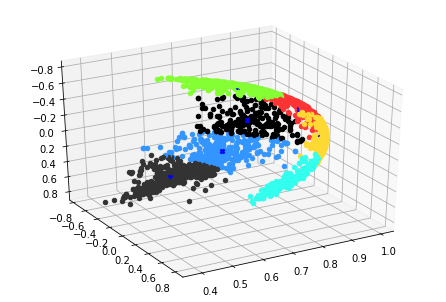

In [22]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 45.06079385056552
Generation: 2 | Best fitness: 39.86592196852598


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 3 | Best fitness: 47.532882329271985
Generation: 4 | Best fitness: 47.532882329272105
Generation: 5 | Best fitness: 49.30691721990992
Generation: 6 | Best fitness: 40.759165277441774
Generation: 7 | Best fitness: 43.699537655182276
Generation: 8 | Best fitness: 63.97745309394183
Generation: 9 | Best fitness: 52.28498530318699
Generation: 10 | Best fitness: 39.158810684967634


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 11 | Best fitness: 39.15881068496792
Generation: 12 | Best fitness: 43.632480623837154
Generation: 13 | Best fitness: 38.92677017894237


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 14 | Best fitness: 41.65172916894888
Generation: 15 | Best fitness: 56.41621147464665


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 16 | Best fitness: 61.03532963264082
Generation: 17 | Best fitness: 61.03532963264088
Generation: 18 | Best fitness: 42.071070445485745
Generation: 19 | Best fitness: 42.071070445485624
Generation: 20 | Best fitness: 40.057164485359586
Generation: 21 | Best fitness: 40.05716448535962
Generation: 22 | Best fitness: 38.849394759331155
Generation: 23 | Best fitness: 51.06608107258333
Generation: 24 | Best fitness: 51.06608107258358
Generation: 25 | Best fitness: 38.338470199115044
Generation: 26 | Best fitness: 36.70045213628561
Generation: 27 | Best fitness: 37.310287999609685
Generation: 28 | Best fitness: 35.54692873485848
Generation: 29 | Best fitness: 35.25135988903891
Generation: 30 | Best fitness: 35.2513598890388
Generation: 31 | Best fitness: 35.95675534799751


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 32 | Best fitness: 36.01903887246598
Generation: 33 | Best fitness: 37.44178104097113
Generation: 34 | Best fitness: 36.17900079536852
Generation: 35 | Best fitness: 37.56250198423229
Generation: 36 | Best fitness: 37.56250198423219
Generation: 37 | Best fitness: 37.44650867618596
Generation: 38 | Best fitness: 34.75848346966425
Generation: 39 | Best fitness: 34.75848346966456
Generation: 40 | Best fitness: 32.90464316440649


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 41 | Best fitness: 32.90464316440667
Generation: 42 | Best fitness: 36.45916814809301
Generation: 43 | Best fitness: 34.24152198870949
Generation: 44 | Best fitness: 35.681048603594995
Generation: 45 | Best fitness: 36.97556554811828
Generation: 46 | Best fitness: 34.7103398427383
Generation: 47 | Best fitness: 37.22032444102278
Generation: 48 | Best fitness: 37.50943232453531
Generation: 49 | Best fitness: 37.50943232453507
Generation: 50 | Best fitness: 33.138275996091124
Generation: 51 | Best fitness: 34.768816436446436
Generation: 52 | Best fitness: 34.768816436446095
Generation: 53 | Best fitness: 34.415726616631204
Generation: 54 | Best fitness: 35.05096070759914
Generation: 55 | Best fitness: 33.271638822379515
Generation: 56 | Best fitness: 31.507742012354036
Generation: 57 | Best fitness: 36.88923918176243
Generation: 58 | Best fitness: 35.086440158690124
Generation: 59 | Best fitness: 32.123260724296784
Generation: 60 | Best fitness: 33.46528463731223
Generation: 

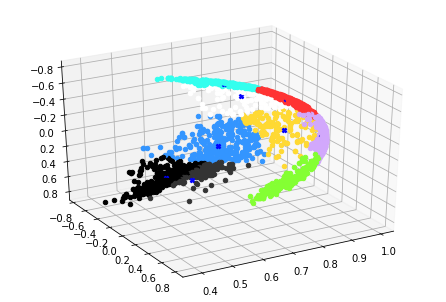

In [23]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
# print("Dunn Index      :"+str(dunn_index(chromosome)))
plot(chromosome)